# Exploratory data analysis

Importerer pakker

In [3]:
import json
import requests
import pandas as pd
import numpy as np
import collections
from pathlib import Path
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

import menon_styles

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('float_format', '{:.2f}'.format)

Menon-farger

In [4]:
menon_styles.menon_styles()

## Read data

Data from Kaggle: https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017

In [5]:
df = (pd
      .read_csv(Path('../data/results.csv'), converters={'date': pd.to_datetime})
      .apply(lambda col: col.str.replace('Korea Republic', 'South Korea') if col.name in ['home_team', 'away_team'] else col)
      .assign(total_goals = lambda df: df.home_score + df.away_score)
      .assign(abs_goal_diff = lambda df: np.abs(df.home_score-df.away_score))
      .assign(home_win = lambda df: df.home_score > df.away_score)
      .assign(away_win = lambda df: df.home_score < df.away_score)
     )
df.to_pickle(Path('../data/raw.pkl'))
df.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_goals,abs_goal_diff,home_win,away_win
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0,0,False,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,6,2,True,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,3,1,True,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,4,0,False,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,3,3,True,False
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False,4,4,True,False
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False,4,2,False,True
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False,2,2,False,True
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False,9,5,True,False
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False,9,9,True,False


### Transform to long

In [6]:
df_home = (df
           .rename(columns={'home_score': 'goals_scored', 'away_score': 'goals_admitted', 'away_team': 'opponent'})
           .pipe(lambda df: df.drop(labels = [col for col in list(df) if 'away' in col], axis=1))
           .rename(columns = lambda name: name.replace('home_', ''))
           .assign(home_field = lambda df: ~df.neutral.values)
           .sort_values(by=['team', 'date'], ascending=[True, True])
           .reset_index(drop=True)
          )
df_away = (df
           .rename(columns={'away_score': 'goals_scored', 'home_score': 'goals_admitted', 'home_team': 'opponent'})
           .pipe(lambda df: df.drop(labels = [col for col in list(df) if 'home' in col], axis=1))
           .rename(columns = lambda name: name.replace('away_', ''))
           .assign(home_field = False)
           .sort_values(by=['team', 'date'], ascending=[True, True])
           .reset_index(drop=True)
          )

df_long = (pd
           .concat([df_home, df_away])
           .sort_values(by=['team', 'date'], ascending=[True, True])
           .reset_index(drop=True)
          )
df_long.to_pickle(Path('../data/long.pkl'))
df_long.head(10)

,abs_goal_diff,city,country,date,goals_admitted,goals_scored,home_field,neutral,opponent,team,total_goals,tournament,win
0,2,Kabul,Afghanistan,1941-08-10,3,1,True,False,India,Afghanistan,4,Friendly,False
1,4,Teheran,Iran,1950-10-26,4,0,False,False,Iran,Afghanistan,4,Friendly,False
2,2,Baghdad,Iraq,1975-04-02,2,0,False,True,Saudi Arabia,Afghanistan,2,AFC Asian Cup qualification,False
3,4,Baghdad,Iraq,1975-04-04,4,0,False,False,Iraq,Afghanistan,4,AFC Asian Cup qualification,False
4,1,Baghdad,Iraq,1975-04-06,2,1,False,True,Qatar,Afghanistan,3,AFC Asian Cup qualification,False
5,6,Baghdad,Iraq,1975-04-10,6,0,False,True,Saudi Arabia,Afghanistan,6,AFC Asian Cup qualification,False
6,0,Baghdad,Iraq,1975-04-12,1,1,False,True,Qatar,Afghanistan,2,AFC Asian Cup qualification,False
7,2,Baghdad,Iraq,1975-04-14,3,1,False,False,Iraq,Afghanistan,4,AFC Asian Cup qualification,False
8,1,Kabul,Afghanistan,1976-07-19,0,1,True,False,Pakistan,Afghanistan,1,Friendly,True
9,0,Kabul,Afghanistan,1976-07-24,1,1,True,False,India,Afghanistan,2,Friendly,False


In [7]:
teams = (df_long
         .assign(games=1)
         .groupby('team')
         [['games', 'win']]
         .sum()
         .reset_index()
         .sort_values(by='team', ascending=True)
         .reset_index()
         .rename(columns={'index': 'team_idx'})
        )
teams.to_pickle(Path('../data/teams.pkl'))
teams.head(20)

,team_idx,team,games,win
0,0,Afghanistan,103,29.00
1,1,Albania,314,78.00
2,2,Algeria,482,202.00
3,3,American Samoa,42,4.00
4,4,Andorra,146,5.00
5,5,Angola,329,112.00
6,6,Anguilla,50,3.00
7,7,Antigua and Barbuda,184,57.00
8,8,Argentina,952,511.00
9,9,Armenia,192,45.00


## EDA

Games per year

In [8]:
games_per_year = (df
                  .assign(games=1)
                  .groupby(df.date.dt.year)
                  .games
                  .count()
                  .to_frame()
                  )

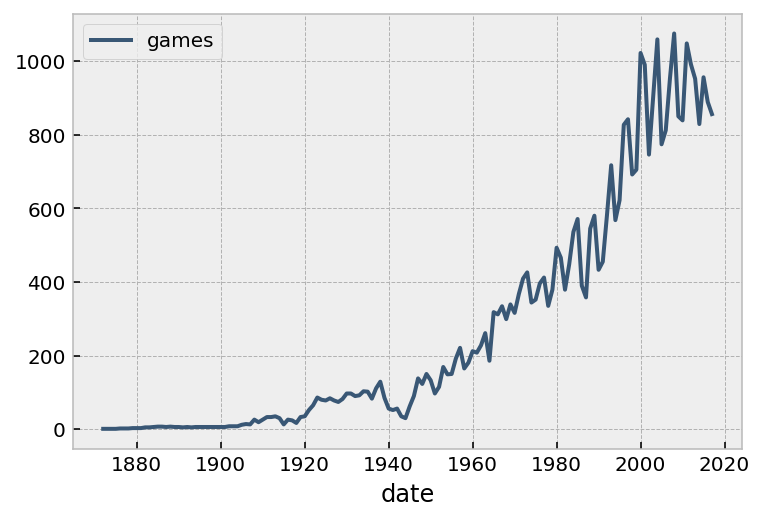

In [9]:
games_per_year.query('date < 2018').plot()

Games per day

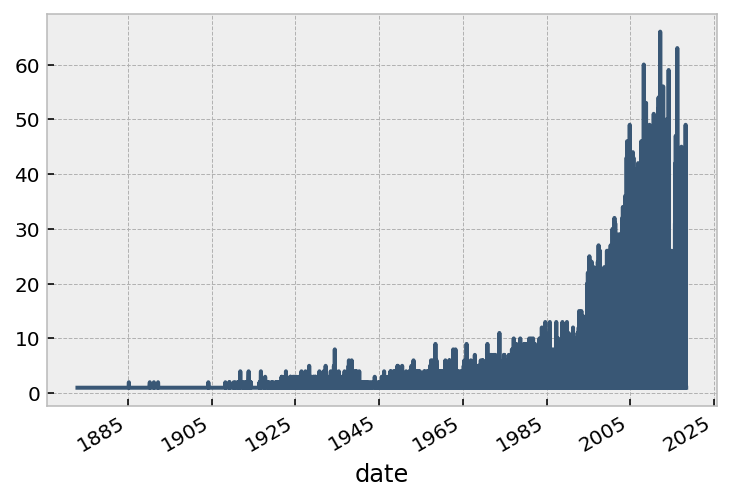

In [10]:
games_per_day = df.assign(games=1).groupby('date').games.sum()
games_per_day.plot()

In [11]:
per_day = df.merge(right=games_per_day.to_frame().reset_index(), on='date')
per_day.loc[per_day['games'] > 40]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_goals,abs_goal_diff,home_win,away_win,games
25975,2004-02-18,Albania,Sweden,2,1,Friendly,Tirana,Albania,False,3,1,True,False,43
25976,2004-02-18,Antigua and Barbuda,Curaçao,2,0,FIFA World Cup qualification,St. John's,Antigua and Barbuda,False,2,2,True,False,43
25977,2004-02-18,Bahrain,Syria,2,1,FIFA World Cup qualification,Muharraq,Bahrain,False,3,1,True,False,43
25978,2004-02-18,Belgium,France,0,2,Friendly,Brussels,Belgium,False,2,2,False,True,43
25979,2004-02-18,China,Kuwait,1,0,FIFA World Cup qualification,Guangzhou,China,False,1,1,True,False,43
25980,2004-02-18,Croatia,Germany,1,2,Friendly,Split,Croatia,False,3,1,False,True,43
25981,2004-02-18,Cyprus,Belarus,0,2,Cyprus International Tournament,Achna,Cyprus,False,2,2,False,True,43
25982,2004-02-18,Estonia,Moldova,1,0,Malta International Tournament,Attard,Malta,True,1,1,True,False,43
25983,2004-02-18,Greece,Bulgaria,2,0,Friendly,Athens,Greece,False,2,2,True,False,43
25984,2004-02-18,Haiti,Turks and Caicos Islands,5,0,FIFA World Cup qualification,Miami,USA,True,5,5,True,False,43


Games per country

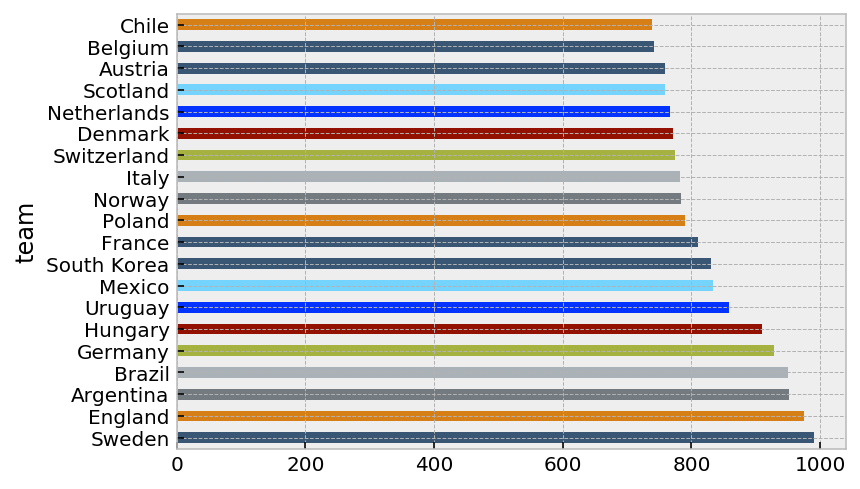

In [12]:
games_per_country = (df_long
                     .assign(games=1)
                     .groupby('team')
                     .games
                     .sum()
                     .sort_values(ascending=False)
                    )
games_per_country.iloc[:20].plot(kind='barh')

Games per team per day

In [13]:
per_team_per_day = (df_long
                    .assign(games=1)
                    .groupby(['date', 'team'])
                    .games
                    .sum()
                    .reset_index()
                    .sort_values(by='games', ascending=False)
                   )
per_team_per_day.head(10)

,date,team,games
2605,1930-09-28,Sweden,3
1480,1923-12-02,Argentina,3
57822,2007-06-24,Korea DPR,2
19655,1976-11-28,Suriname,2
158,1892-03-05,England,2
3540,1935-09-15,Poland,2
3538,1935-09-15,Germany,2
21799,1979-10-22,St. Vincent and the Grenadines,2
21798,1979-10-22,Guadeloupe,2
2971,1932-10-02,Poland,2


In [14]:
per_team_per_day.games.value_counts()

1    77650
2      101
3        2
Name: games, dtype: int64

In [15]:
per_team_per_day = (df
                    .assign(games=1)
                    .groupby(['date', 'home_team'])
                    .games
                    .sum()
                    .reset_index()
                    .sort_values(by='games', ascending=False)
                   )
per_team_per_day.loc[per_team_per_day.games > 1]

,date,home_team,games
9280,1975-06-29,Mozambique,2
28883,2007-06-12,Réunion,2
5376,1963-08-14,Sweden,2
6362,1967-03-07,Libya,2
742,1923-11-25,Uruguay,2
743,1923-12-02,Argentina,2
2015,1938-03-20,Germany,2
657,1922-10-22,Brazil,2
8800,1974-02-17,Tahiti,2
6529,1967-10-10,Tanzania,2


Win percentage per country

In [16]:
PRIOR_ALPHA, PRIOR_BETA = 10, 10
win_pct_country = (df_long
                   .assign(games=1)
                   .groupby('team')
                   .agg({'games': np.sum, 'win': np.sum})
                   .assign(win_pct_raw = lambda df: df.win/df.games)
                   .assign(win_pct_beta = lambda df: (PRIOR_ALPHA+df.win)/(PRIOR_ALPHA + PRIOR_BETA+df.games))
                   .sort_values(by='win_pct_beta', ascending=False)
                  )
win_pct_country.head()

,games,win,win_pct_raw,win_pct_beta
team,,,,
Brazil,950,605.00,0.64,0.63
Germany,928,544.00,0.59,0.58
Spain,668,389.00,0.58,0.58
England,975,552.00,0.57,0.56
Iran,475,258.00,0.54,0.54


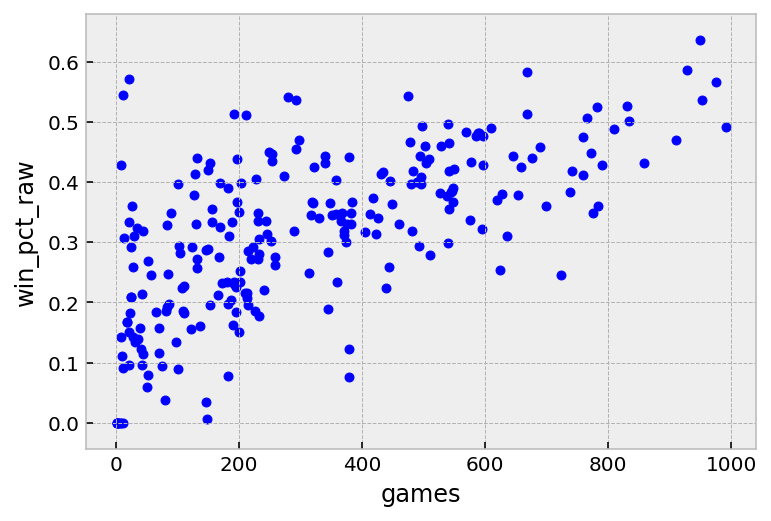

In [17]:
win_pct_country.plot(kind='scatter', x='games', y='win_pct_raw')